In [859]:
import tensorflow as tf
# tf.enable_eager_execution()
tf.__version__

'2.8.2'

In [860]:
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

In [861]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255
ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(300)

In [862]:
def show(df):
  fig, ax = plt.subplots(ncols = 5, figsize = (10,10))
  for idx in range(5): 
      sample = df[idx]
      ax[idx].imshow(sample)
      ax[idx].title.set_text(idx)

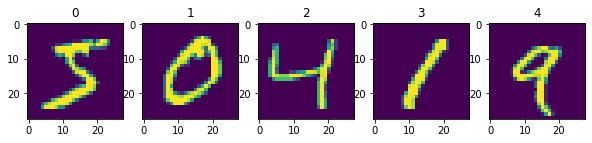

In [863]:
show(train_images)

In [864]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D , BatchNormalization , Conv2DTranspose
import tensorflow as tf
def generator():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(200,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7,7, 256)))
    assert model.output_shape == (None, 7,7, 256)  # Note: None is the batch size
    model.add(Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 7,7, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2 , 2) ,  padding='same', use_bias=False))
    assert model.output_shape == (None, 14,14 , 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(64, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 14,14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2 , 2) ,  padding='same', use_bias=False))
    assert model.output_shape == (None, 28,28 , 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (3,3), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28,28, 1)
    return model

In [865]:
generator = generator()
generator.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 12544)             2508800   
                                                                 
 batch_normalization_217 (Ba  (None, 12544)            50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_291 (LeakyReLU)  (None, 12544)            0         
                                                                 
 reshape_51 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_105 (Conv2  (None, 7, 7, 64)         409600    
 DTranspose)                                                     
                                                                 
 batch_normalization_218 (Ba  (None, 7, 7, 64)       

In [866]:
generated_image = generator.predict(np.random.randn(5 , 200 , 1))

In [867]:
def show2(df):
  fig, ax = plt.subplots(ncols = 5, figsize = (10,10))
  for idx, img in enumerate(df): 
      ax[idx].imshow(np.squeeze(img)) 
      ax[idx].title.set_text(idx)

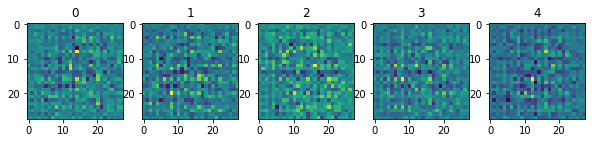

In [868]:
show2(generated_image)

In [876]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(128, (3,3), padding='same',
                                     input_shape=[28, 28 , 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1 , activation = 'sigmoid'))
    return model

In [877]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization_231 (Ba  (None, 28, 28, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_302 (LeakyReLU)  (None, 28, 28, 128)      0         
                                                                 
 dropout_78 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_205 (Conv2D)         (None, 28, 28, 128)       147584    
                                                                 
 batch_normalization_232 (Ba  (None, 28, 28, 128)      512       
 tchNormalization)                                  

In [878]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[0.5057371 ]
 [0.50584084]
 [0.50567645]
 [0.50574857]
 [0.50594527]], shape=(5, 1), dtype=float32)


In [879]:
loss = tf.keras.losses.BinaryCrossentropy()

g_opt = tf.keras.optimizers.Adam(0.0001)
d_opt = tf.keras.optimizers.Adam(0.00001)

In [880]:
from tensorflow.keras.models import Model
class customized(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.loss = loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((1 , 200)), training = False)
        

        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training = True) 
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
    
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            total_d_loss = self.loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
 
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((1 , 200)), training = True)
            predicted_labels = self.discriminator(gen_images, training = False)
                                        
            total_g_loss = self.loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [881]:
fashgan = customized(generator, discriminator)

In [882]:
fashgan.compile(g_opt, d_opt, loss)

In [887]:
hist = fashgan.fit(ds, epochs = 50)

Epoch 1/50
200/200 [==============================] - 14s 70ms/step - d_loss: 0.7860 - g_loss: 9.0097e-05
Epoch 2/50
200/200 [==============================] - 14s 69ms/step - d_loss: 0.7833 - g_loss: 1.9815e-04
Epoch 3/50
200/200 [==============================] - 14s 69ms/step - d_loss: 0.7714 - g_loss: 3.7412e-04
Epoch 4/50
200/200 [==============================] - 14s 69ms/step - d_loss: 0.7592 - g_loss: 6.3461e-04
Epoch 5/50
200/200 [==============================] - 14s 70ms/step - d_loss: 0.7522 - g_loss: 8.8985e-04
Epoch 6/50
200/200 [==============================] - 14s 69ms/step - d_loss: 0.7387 - g_loss: 0.0013
Epoch 7/50
200/200 [==============================] - 14s 70ms/step - d_loss: 0.7327 - g_loss: 0.0015
Epoch 8/50
200/200 [==============================] - 14s 70ms/step - d_loss: 0.7257 - g_loss: 0.0019
Epoch 9/50
200/200 [==============================] - 14s 70ms/step - d_loss: 0.7171 - g_loss: 0.0026
Epoch 10/50
200/200 [==============================] - 14s 70m

In [888]:
imgs = generator.predict(np.random.randn(5 , 200 , 1))

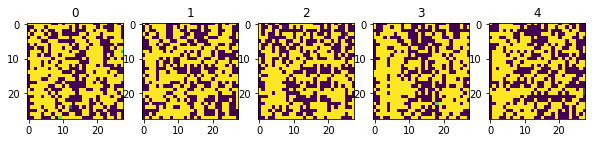

In [889]:
show2(imgs)

In [890]:
decision = discriminator(imgs)
print (decision)

tf.Tensor(
[[0.3547443 ]
 [0.22249019]
 [0.13723792]
 [0.17262019]
 [0.2995706 ]], shape=(5, 1), dtype=float32)
